# Installing Imporant Packages

In [1]:
import warnings

# Ignore DeprecationWarning and UserWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
!pip install stable_baselines3 pyfolio pandas_datareader==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 M

# PreProcessing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf

In [4]:
def bullish_trend(start="2013-04-01", end="2024-04-01"):
    companies = ["AAPL", "GE", "JPM", "MSFT", "VOD", "NKE", "NVDA", "MMM"]

    dfs = []

    for company in companies:

        company_data = yf.download(company, start=start, end=end)

        dfs.append(company_data)

    data = pd.concat([df["Adj Close"] for df in dfs], axis=1, keys=companies)

    data = data.ffill().bfill()

    return data

In [5]:
def bearish_trend(start="2013-04-01", end="2024-04-01"):
    companies = [
        "CONSOFINVT.NS",
        "WSTCSTPAPR.NS",
        "INDOBORAX.NS",
        "DVL.NS",
        "DCW.NS",
        "BEPL.NS",
        "AGARIND.NS",
        "DATAMATICS.NS",
        "BANSWRAS.NS",
    ]

    dfs = []

    for company in companies:
        company_data = yf.download(company, start=start, end=end)
        dfs.append(company_data)

    data = pd.concat([df["Adj Close"] for df in dfs], axis=1, keys=companies)
    data = data.ffill().bfill()

    return data

### Visualisation

In [6]:
def visualise_data(data, trend: str):
    # Set the figure size once, globally for all plots
    plt.rcParams["figure.figsize"] = (10, 6)

    ax = data.plot()

    # Set labels and title
    ax.set_ylabel("Closing Share Price (USD)")
    ax.set_xlabel("Time (Years)")

    # Remove x-axis margins
    ax.margins(x=0)

    # Save the figure
    plt.savefig(f"{trend}_data.png", bbox_inches="tight")

## Creating Environment for Deep RL

In [7]:
import numpy as np
import time
import gym
from gym.utils import seeding
from gym import spaces
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3


# 10 shares per trade-share
#  It indicates the maximum number of shares that can be bought or sold in a single brokerage
SHARE_NORMALIZE_COEFF = 10
# initial amount of money we have in our account
ACCOUNT_BALANCE_INITIAL = 0
# brokerage fee: 1/1000 reasonable percentage
BROKERAGE_FEE_PERCENT = 0.001


class StockEnvTrade(gym.Env):
    """A stock trading environment for OpenAI gym"""

    # Define metadata for the environment
    metadata = {"render.modes": ["human"]}

    def __init__(self, df, day=0, initial=True):
        """
        Initialize the stock trading environment.

        Parameters:
            df (DataFrame): DataFrame containing stock data.
            day (int): Starting day for trading. Defaults to 0.
            initial (bool): Flag indicating whether to initialize the environment with initial values. Defaults to True.
        """

        self.df = df  # Store the DataFrame containing stock data
        self.day = day  # Initialize the starting day for trading
        self.initial = initial  # Initialize the initial flag

        # Total number of stocks in our portfolio
        self.stock_dim = self.df.shape[1]

        # Action Space
        # Define action_space normalization and shape as self.stock_dim
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.stock_dim,))

        # State Space
        # Shape = 1 + 2 * self.stock_dim: [Current Balance] + [Prices] + [Owned Shares]
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(2 * self.stock_dim + 1,)
        )

        # Load data from a pandas DataFrame
        self.data = self.df.iloc[self.day, :]
        self.terminal = False  # Flag indicating if the episode has terminated

        # Initialize state
        self.state = (
            [ACCOUNT_BALANCE_INITIAL] + self.data.values.tolist() + [0] * self.stock_dim
        )

        # Initialize reward
        self.reward = 0

        # Memorize all the total balance changes
        self.asset_memory = [ACCOUNT_BALANCE_INITIAL]
        self.actions_memory = [[1 / self.stock_dim] * self.stock_dim]

        self._seed(0)  # Set the random seed for reproducibility

    def _sell_stock(self, index, action):
        """
        Sell a stock based on the provided action.

        Parameters:
            index (int): Index of the stock in the state representation.
            action (float): Action representing the quantity of stock to sell.
        """
        # Round the action to the nearest integer since we cannot sell fractional shares
        action = np.floor(action)

        # Check if there are shares of the stock to sell
        if self.state[index + self.stock_dim + 1] > 0:
            # Update the balance by subtracting the value of the sold shares (price * quantity) and brokerage fees
            self.state[0] += (
                self.state[index + 1]
                * min(abs(action), self.state[index + self.stock_dim + 1])
                * (1 - BROKERAGE_FEE_PERCENT)
            )

            # Update the number of shares owned
            self.state[index + self.stock_dim + 1] -= min(
                abs(action), self.state[index + self.stock_dim + 1]
            )
        else:
            pass  # If there are no shares of the stock to sell, do nothing

    def _buy_stock(self, index, action):
        """
        Buy a stock based on the provided action.

        Parameters:
            index (int): Index of the stock in the state representation.
            action (float): Action representing the quantity of stock to buy.
        """
        # Round the action to the nearest integer since we cannot buy fractional shares
        action = np.floor(action)

        # Update the balance by subtracting the value of the bought shares (price * quantity) and brokerage fees
        self.state[0] -= self.state[index + 1] * action * (1 + BROKERAGE_FEE_PERCENT)

        # Update the number of shares owned
        self.state[index + self.stock_dim + 1] += action

    def step(self, actions):
        """
        Execute one step of the environment.

        Parameters:
            actions (array): Array of actions, one for each stock in the portfolio.

        Returns:
            state (array): The new state after taking the step.
            reward (float): The reward obtained from taking the step.
            terminal (bool): Indicates whether the episode has terminated.
            info (dict): Additional information (not used in this implementation).
        """
        # Check if the episode has terminated
        self.terminal = self.day >= len(self.df.index.unique()) - 1

        # If the episode has terminated, return the current state, reward, terminal flag, and empty info
        if self.terminal:
            return self.state, self.reward, self.terminal, {}

        else:
            # Scale the actions by SHARE_NORMALIZE_COEFF
            actions = actions * SHARE_NORMALIZE_COEFF

            # Calculate the total asset value at the beginning of the step
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )

            # Sort the actions and identify indices of stocks to sell and buy
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            # Sell stocks
            for index in sell_index:
                self._sell_stock(index, actions[index])

            # Buy stocks
            for index in buy_index:
                self._buy_stock(index, actions[index])

            # Update the day and load data for the next day
            self.day += 1
            self.data = self.df.iloc[self.day, :]

            # Update the state with the new values of account balance and stock prices
            self.state = (
                [self.state[0]]
                + self.data.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )

            # Calculate the total asset value at the end of the step
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )

            # Calculate the reward as the difference in total asset value
            self.reward = end_total_asset - begin_total_asset

            # Normalize the weights of owned stocks and append them to the actions memory
            weights = self.normalization(
                np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.actions_memory.append(weights.tolist())

            # Return the new state, reward, terminal flag, and empty info
            return self.state, self.reward, self.terminal, {}

    def reset(self):

        self.day = 0
        self.data = self.df.iloc[self.day, :]
        self.terminal = False

        # memorize all the total balance change
        self.actions_memory = [[1 / self.stock_dim] * self.stock_dim]

        # initiate state
        self.state = (
            [ACCOUNT_BALANCE_INITIAL] + self.data.values.tolist() + [0] * self.stock_dim
        )

        self._seed(0)

        return self.state

    def normalization(self, actions):
        output = actions / (np.sum(actions) + 1e-15)
        return output

    def save_action_memory(self):
        return self.actions_memory

    def render(self, mode="human", close=False):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


def train(
    algo: str,
    policy: str,
    env_train: gym.Env,
    timesteps: int,
    seed: int = None,
    save: bool = True,
):
    """
    Train a reinforcement learning model using the specified algorithm.

    Parameters:
        algo (str): The RL algorithm to use for training.
        policy (str): The policy architecture for the RL model.
        env_train (gym.Env): The training environment.
        timesteps (int): The total number of training timesteps.
        seed (int): The random seed for reproducibility. Defaults to None.
        save (bool): Indicates whether to save the trained model. Defaults to True.

    Returns:
        model: The trained RL model.
    """
    start = time.time()  # Record the start time of training
    model = None
    try:
        # Initialize the RL model based on the specified algorithm
        if algo == "PPO":
            model = PPO(policy, env_train, verbose=0, seed=seed)
        elif algo == "A2C":
            model = A2C(policy, env_train, verbose=0, seed=seed)
        elif algo == "SAC":
            model = SAC(policy, env_train, verbose=0, seed=seed)
    except Exception as e:
        print(f"Error as {e}")
        return None

    # Train the RL model for the specified number of timesteps
    model.learn(total_timesteps=timesteps)

    end = time.time()  # Record the end time of training

    # Optionally save the trained model
    if save:
        model.save("results/" + algo + "_" + str(timesteps) + "_model")

    # Print the training time
    print("Training time: ", (end - start) / 60, " minutes")

    return model


def DRL_prediction(model, data, env, obs):
    """
    Use a trained DRL model to make predictions in a trading environment.

    Parameters:
        model: The trained DRL model.
        data: Data used for prediction (typically unseen data).
        env: The trading environment.
        obs: The initial observation/state of the environment.

    Returns:
        actions_memory[0]: The predicted actions made by the model.
    """
    actions_memory = []  # Initialize a list to store the actions made by the model
    model.set_random_seed(10)  # Set a random seed for reproducibility

    # Iterate over each timestep in the data
    for i in range(len(data.index.unique())):
        # Predict the action to take based on the current observation
        action, _states = model.predict(obs)

        # Execute the predicted action in the environment and obtain the next observation, rewards, and terminal flag
        obs, rewards, dones, info = env.step(action)

        # If it's the second-to-last timestep, save the action memory for analysis
        if i == (len(data.index.unique()) - 2):
            actions_memory = env.env_method(method_name="save_action_memory")

    # Return the predicted actions made by the model
    return actions_memory[0]

In [8]:
import numpy as np
import random
from stable_baselines3.common.vec_env import DummyVecEnv

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Evaluating models

In [9]:
!pip install 'shimmy>=0.2.1'

In [10]:
def plot(
    Cumulative_returns_daily_drl,
    portfolio_weights,
    algo,
    test_df,
    timesteps,
    rebalance_period,
    companies,
    trend,
):

    fig, axs = plt.subplots(2, 2, figsize=(17, 10), constrained_layout=True)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    algo_mean = np.mean(np.array(Cumulative_returns_daily_drl), axis=0)
    algo_std = np.std(np.array(Cumulative_returns_daily_drl), axis=0)
    axs[0, 0].plot(test_df.index, algo_mean, color="tab:blue", linewidth=2.0)
    axs[0, 0].fill_between(
        test_df.index,
        algo_mean - algo_std,
        algo_mean + algo_std,
        alpha=0.2,
        color="tab:blue",
    )
    axs[0, 0].margins(x=0)
    axs[0, 0].margins(y=0)
    axs[0, 0].axhline(1, color="black", linestyle="--", lw=2)
    axs[0, 0].set_ylabel("Cumulative Returns")
    axs[0, 0].set_xlabel("Time (Years-Months)")
    axs[0, 0].set_title("Average Cumulative Return and STD.")

    portfolio_weights_algo_ = np.mean(np.array(portfolio_weights), axis=0)
    df = pd.DataFrame(portfolio_weights_algo_, index=test_df.index, columns=companies)
    axs[0, 1].stackplot(
        test_df.index, *[df[company] for company in companies], labels=companies
    )
    axs[0, 1].legend(loc="upper right")
    axs[0, 1].margins(x=0)
    axs[0, 1].margins(y=0)
    axs[0, 1].set_ylabel("Weights (%)")
    axs[0, 1].set_xlabel("Time (Years-Months)")
    axs[0, 1].set_title("Average Weights vs Time")

    portfolio_weights_algo_ = portfolio_weights[
        np.argmax(Cumulative_returns_daily_drl[:, -1])
    ]
    df = pd.DataFrame(portfolio_weights_algo_, index=test_df.index, columns=companies)
    axs[1, 0].stackplot(
        test_df.index, *[df[company] for company in companies], labels=companies
    )
    axs[1, 0].margins(x=0)
    axs[1, 0].margins(y=0)
    axs[1, 0].set_ylabel("Weights (%)")
    axs[1, 0].set_xlabel("Time (Years-Months)")
    axs[1, 0].set_title("Weights corresponding to Max Cumulative Return VS Time")

    portfolio_weights_algo_ = portfolio_weights[
        np.argmin(Cumulative_returns_daily_drl[:, -1])
    ]
    df = pd.DataFrame(portfolio_weights_algo_, index=test_df.index, columns=companies)
    axs[1, 1].stackplot(
        test_df.index, *[df[company] for company in companies], labels=companies
    )
    axs[1, 1].margins(x=0)
    axs[1, 1].margins(y=0)
    axs[1, 1].set_ylabel("Weights (%)")
    axs[1, 1].set_xlabel("Time (Years-Months)")
    axs[1, 1].set_title("Weights corresponding to min cumulative return VS time")

    fig.suptitle(f"{algo}", fontsize=16)
    plt.savefig(
        algo
        + "_"
        + trend
        + "_"
        + str(timesteps)
        + "_"
        + str(rebalance_period)
        + "_drl0.png",
        bbox_inches="tight",
    )

In [11]:
def rl(algo: str, data, trend):
    train_pct = 0.8
    samples_train = int(train_pct * len(data))
    data_train = data[:samples_train]
    data_test = data[samples_train:]
    companies = data.columns

    rebalance_period = 1
    re_df = data.iloc[::rebalance_period, :]
    train_re_df = data_train.iloc[::rebalance_period, :]
    test_df = data_test.iloc[::rebalance_period, :]

    timesteps = 25000
    epochs = 10
    policy = "MlpPolicy"
    ndays = test_df.shape[0]
    stocks = test_df.shape[1]
    Cumulative_returns_daily_drl = np.zeros([epochs, ndays])
    portfolio_weights = np.zeros([epochs, ndays, stocks])
    i = 0
    cont = 0
    while i < epochs:
        train_env = DummyVecEnv([lambda: StockEnvTrade(df=train_re_df)])
        model = train(algo, policy, train_env, timesteps, seed=cont, save=False)
        test_env = DummyVecEnv([lambda: StockEnvTrade(df=test_df)])
        test_obs = test_env.reset()
        portfolio_weights[i] = np.array(
            DRL_prediction(model, test_df, test_env, test_obs)
        )
        check = np.sum(portfolio_weights[i])
        cont = cont + 1
        if check != ndays:
            continue
        return_stocks = test_df.pct_change()
        return_stocks_ppo = np.sum(return_stocks.multiply(portfolio_weights[i]), axis=1)
        Cumulative_returns_daily_drl[i] = (1 + return_stocks_ppo).cumprod()
        i = i + 1

    plot(
        Cumulative_returns_daily_drl,
        portfolio_weights,
        algo,
        test_df,
        timesteps,
        rebalance_period,
        companies,
        trend,
    )
    return f"{algo} executed successfully"

In [12]:
import warnings

# Ignore DeprecationWarning and UserWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Bullish trend

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


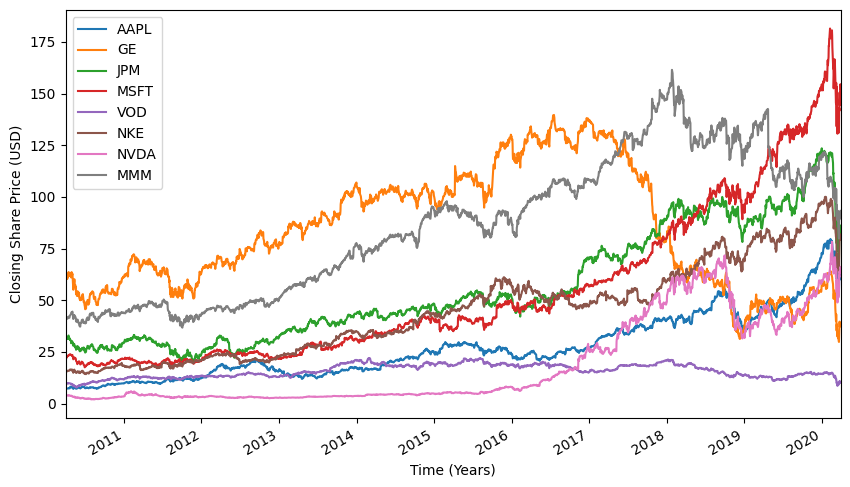

In [13]:
data = bullish_trend(start="2010-04-01", end="2020-04-01")
trend = "Bullish"
visualise_data(data, trend)

Training time:  1.144752852121989  minutes
Training time:  0.9899946173032125  minutes
Training time:  0.9452905416488647  minutes
Training time:  0.9564071496327718  minutes
Training time:  0.9426969528198242  minutes
Training time:  0.9691216071446737  minutes
Training time:  0.9381029923756917  minutes
Training time:  0.9651595671971639  minutes
Training time:  0.9742794871330261  minutes
Training time:  0.9491378188133239  minutes


'PPO executed successfully'

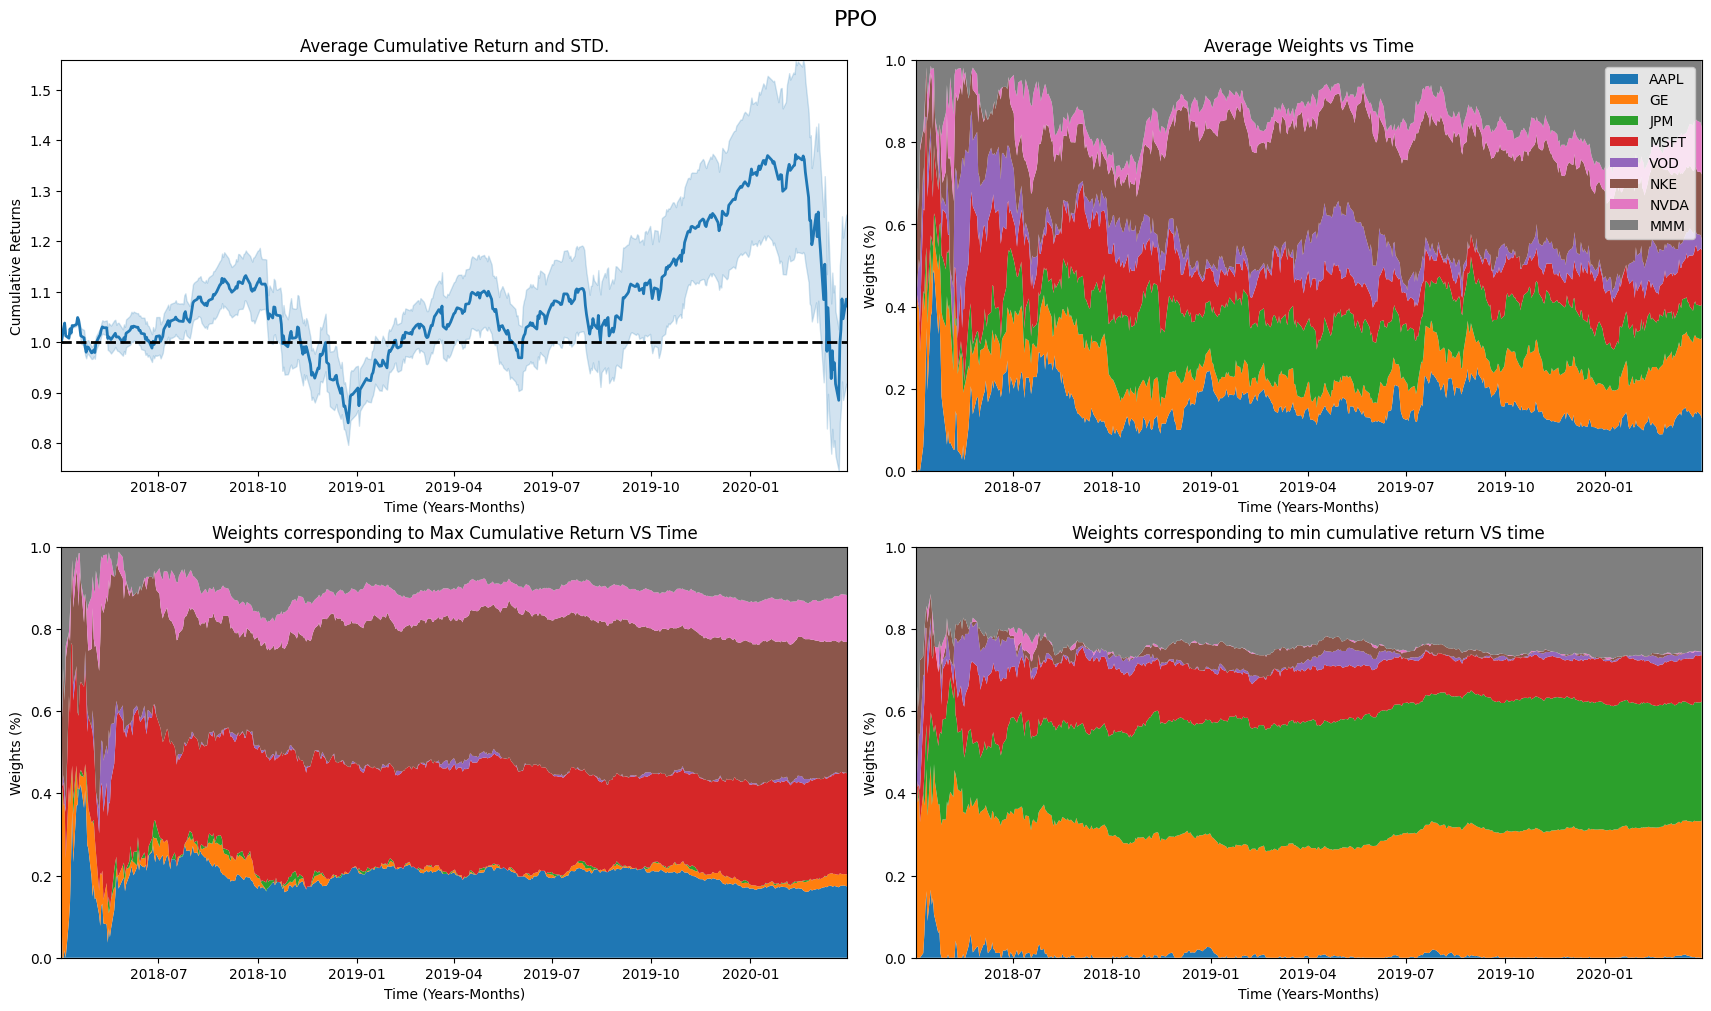

In [14]:
rl("PPO", data, trend)

Training time:  0.983854087193807  minutes
Training time:  0.9868883927663167  minutes
Training time:  0.9660606622695923  minutes
Training time:  0.9771749099095662  minutes
Training time:  0.986234438419342  minutes
Training time:  0.9629241506258647  minutes
Training time:  0.9973120093345642  minutes
Training time:  0.9844470818837484  minutes
Training time:  0.9641128063201905  minutes
Training time:  0.990311324596405  minutes


'A2C executed successfully'

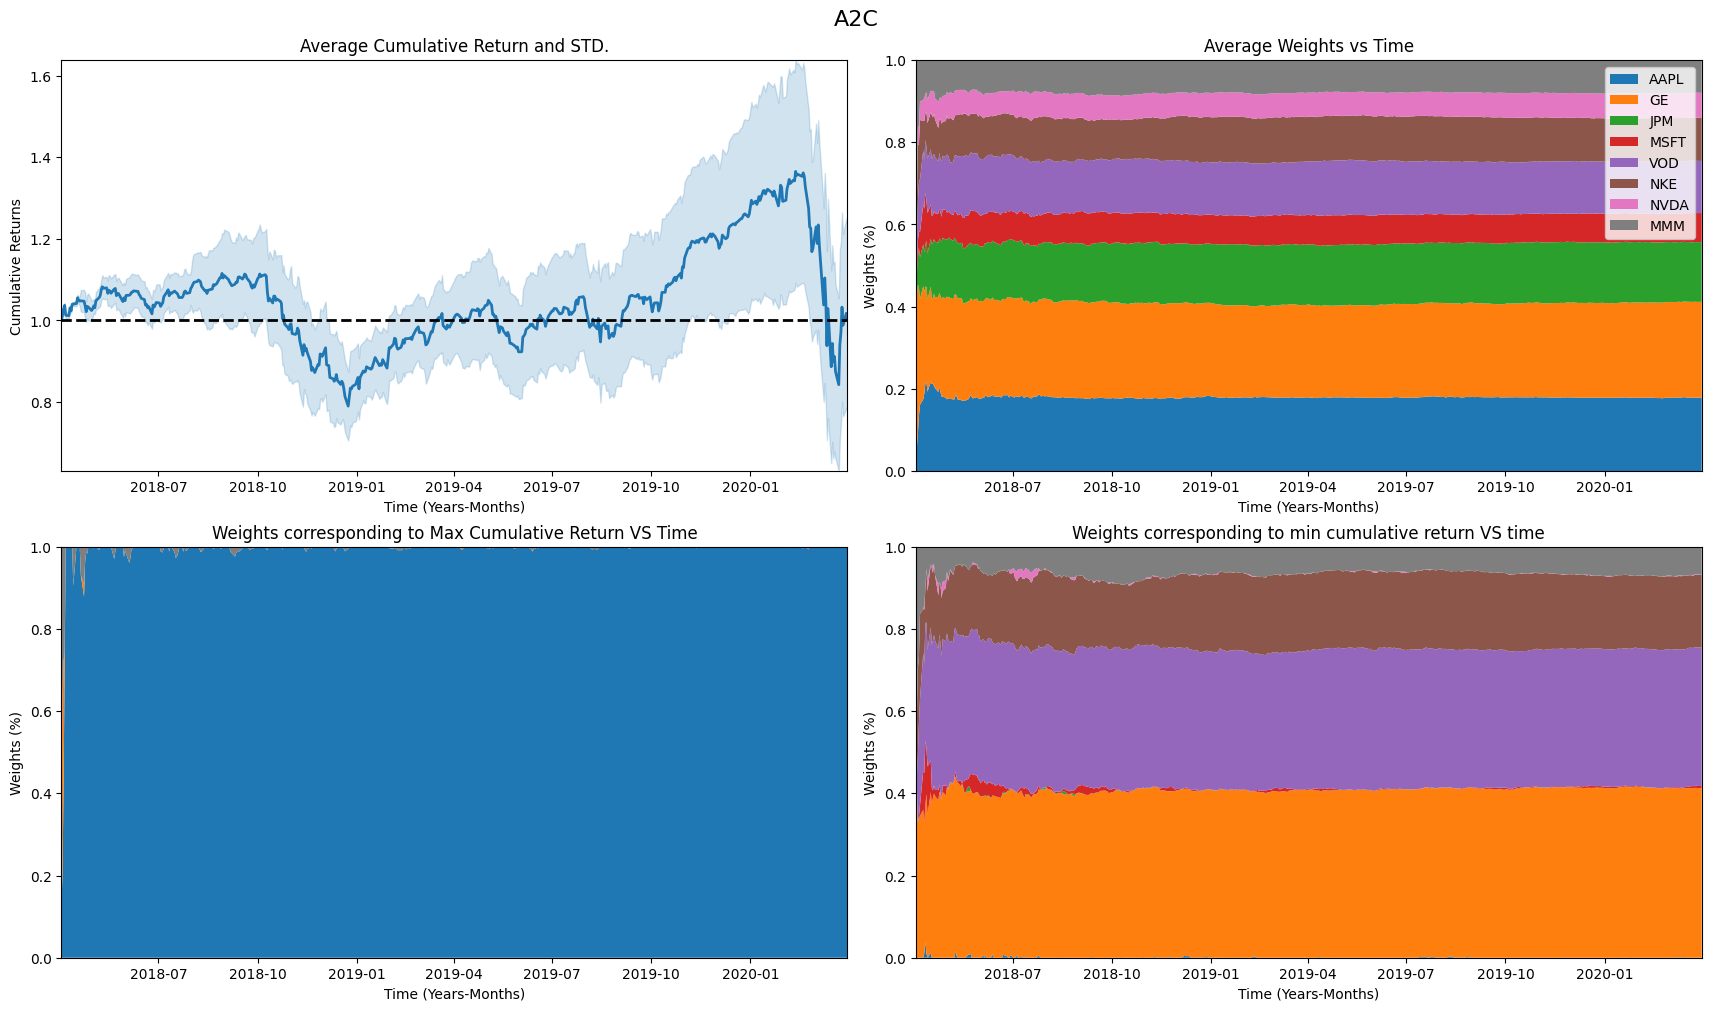

In [15]:
rl("A2C", data, trend)

Training time:  4.952205272515615  minutes
Training time:  4.918897883097331  minutes
Training time:  4.921303904056549  minutes
Training time:  4.92220907608668  minutes
Training time:  4.942434163888295  minutes
Training time:  4.913641516367594  minutes
Training time:  4.926355195045471  minutes
Training time:  4.921881008148193  minutes
Training time:  4.9215098977088925  minutes
Training time:  4.939180910587311  minutes


'SAC executed successfully'

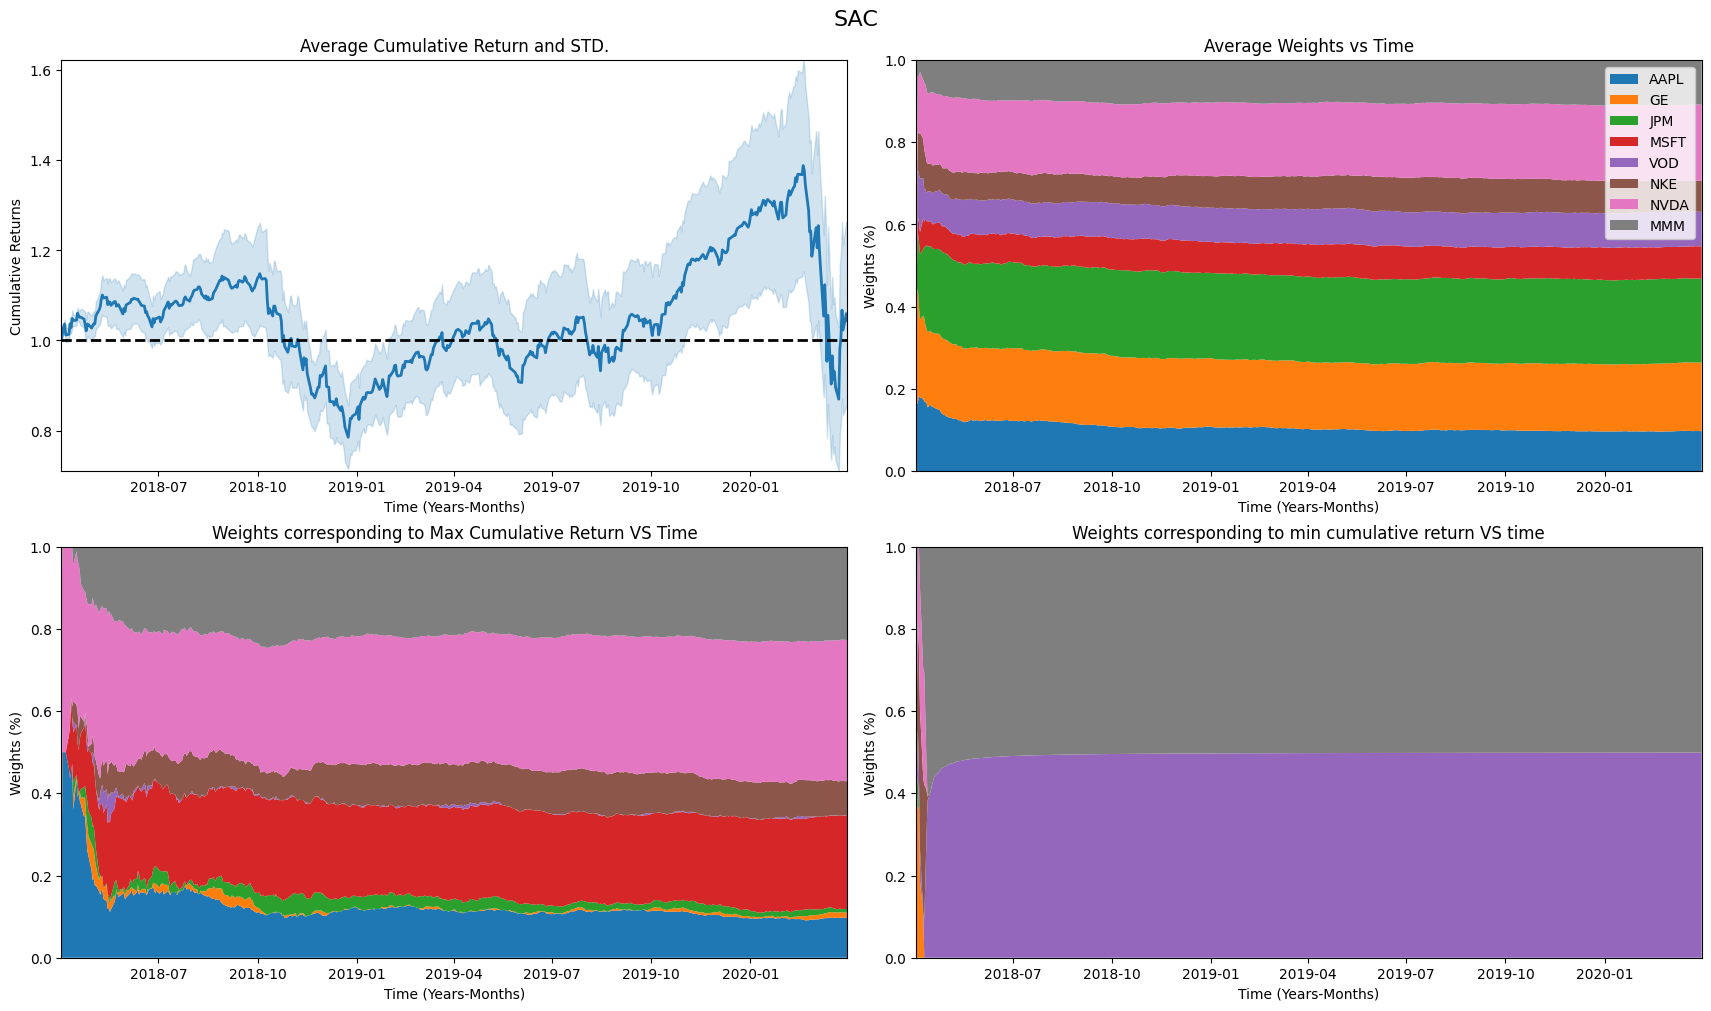

In [16]:
rl("SAC", data, trend)

## Bearish Trend

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


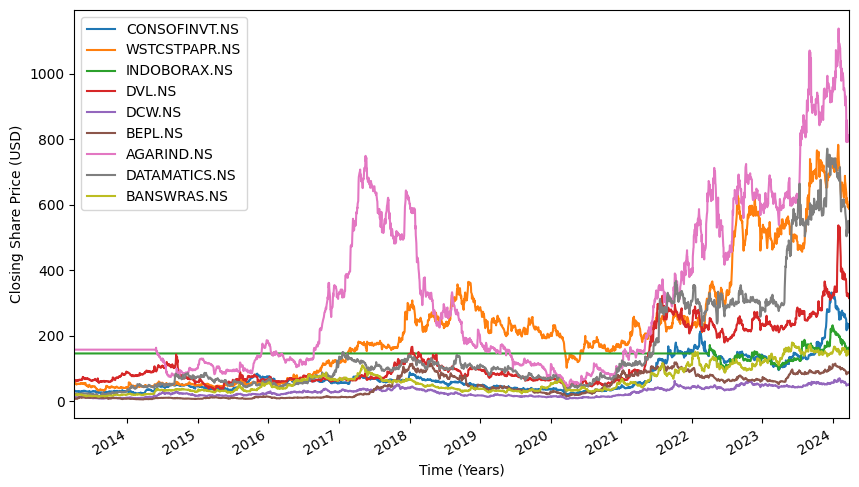

In [23]:
data = bearish_trend(start="2013-04-01", end="2024-04-01")
trend = "Bearish"
visualise_data(data, trend)

In [24]:
data.isna().sum()

CONSOFINVT.NS    0
WSTCSTPAPR.NS    0
INDOBORAX.NS     0
DVL.NS           0
DCW.NS           0
BEPL.NS          0
AGARIND.NS       0
DATAMATICS.NS    0
BANSWRAS.NS      0
dtype: int64

Training time:  0.9906684835751851  minutes
Training time:  0.9672493815422059  minutes
Training time:  0.9573408643404643  minutes
Training time:  0.973526398340861  minutes
Training time:  0.9612411260604858  minutes
Training time:  0.951528533299764  minutes
Training time:  1.0027798692385355  minutes
Training time:  0.9748486002286275  minutes
Training time:  0.9773919781049093  minutes
Training time:  0.9702346762021382  minutes


'PPO executed successfully'

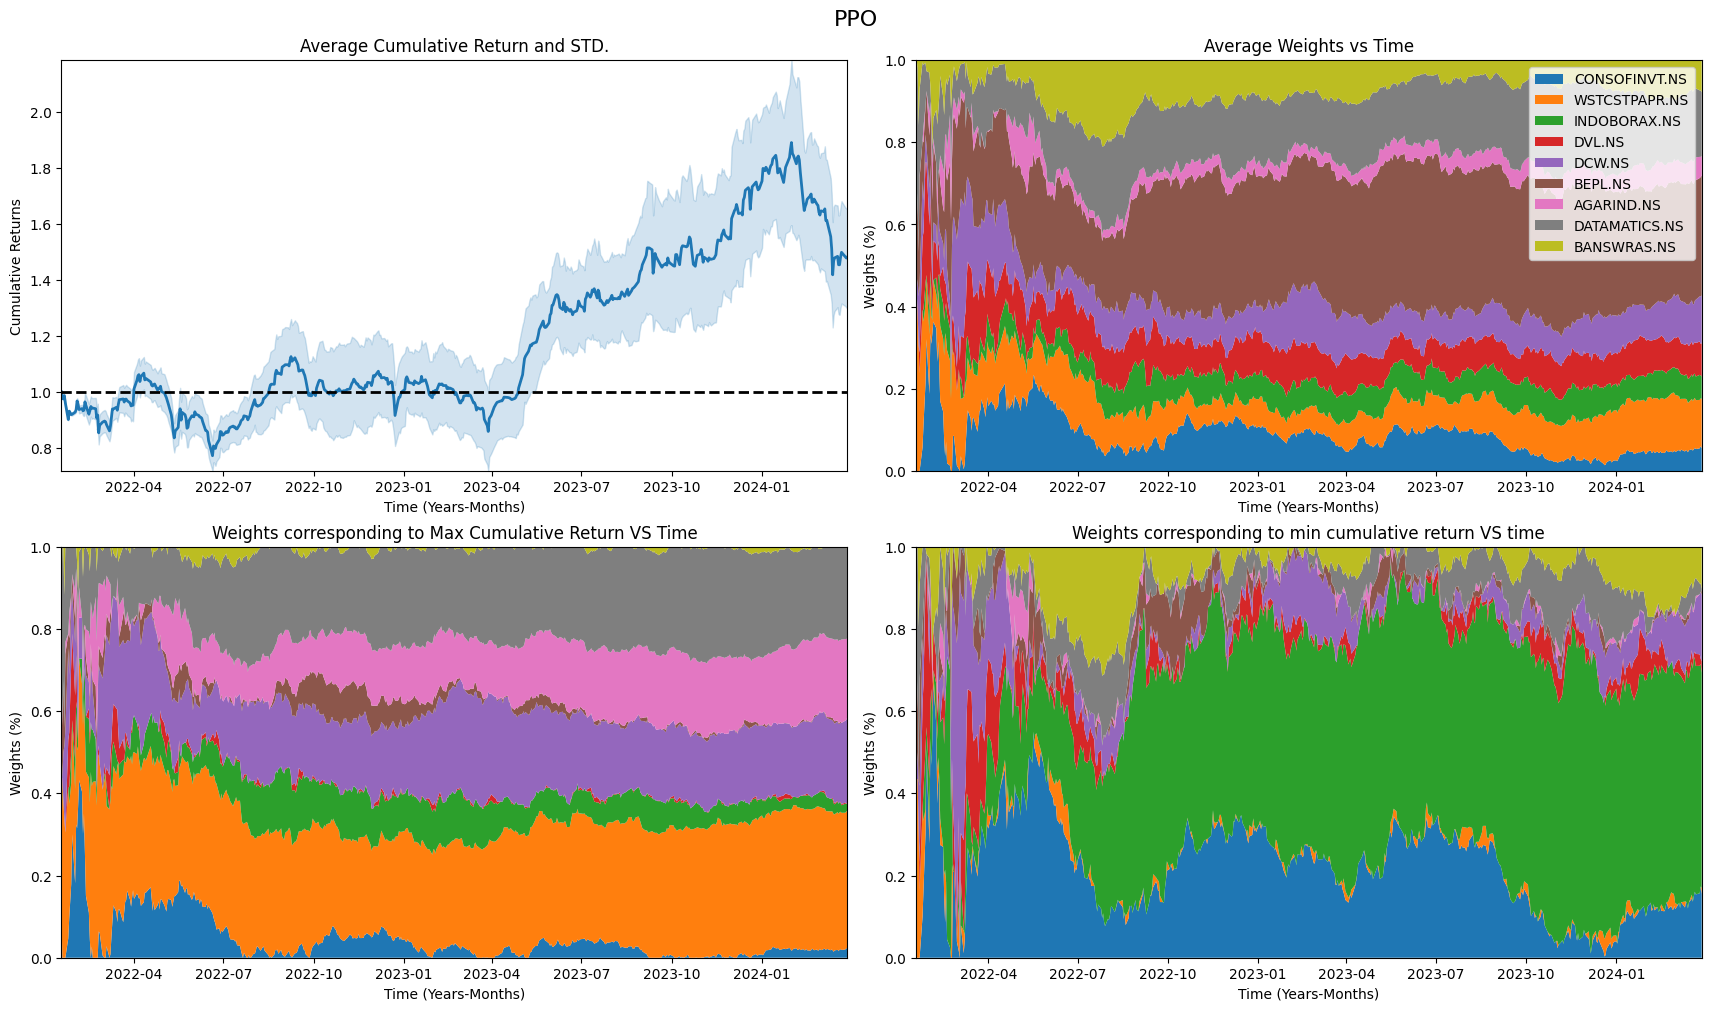

In [25]:
rl("PPO", data, trend)

Training time:  0.9943322936693827  minutes
Training time:  1.0043532093365988  minutes
Training time:  0.9805398543675741  minutes
Training time:  0.9869322101275126  minutes
Training time:  1.004069737593333  minutes
Training time:  0.9859333157539367  minutes
Training time:  1.053105076154073  minutes
Training time:  1.0455498337745666  minutes
Training time:  1.0396609425544738  minutes
Training time:  1.0532451748847962  minutes


'A2C executed successfully'

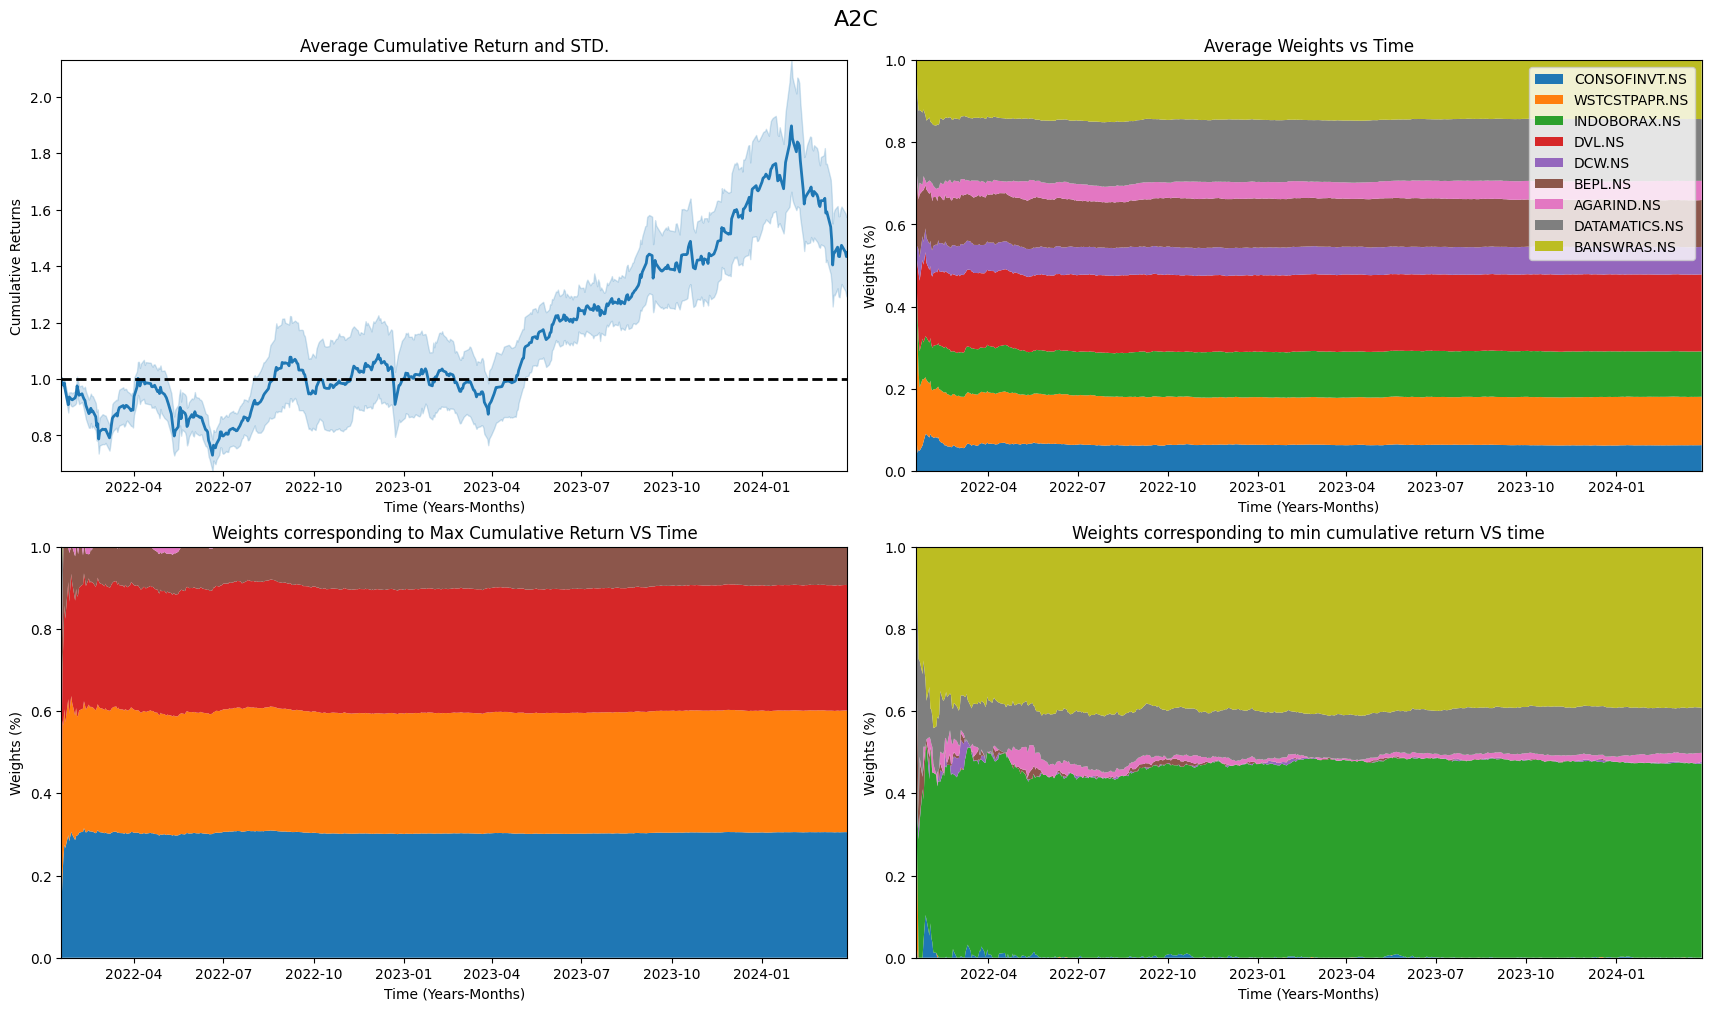

In [26]:
rl("A2C", data, trend)

Training time:  5.087761902809143  minutes
Training time:  4.932714525858561  minutes
Training time:  4.980213944117228  minutes
Training time:  4.919743223985036  minutes
Training time:  4.844678417841593  minutes
Training time:  4.856751096248627  minutes
Training time:  4.867653894424438  minutes
Training time:  4.91336152156194  minutes
Training time:  4.941782399018606  minutes
Training time:  4.957025543848673  minutes


'SAC executed successfully'

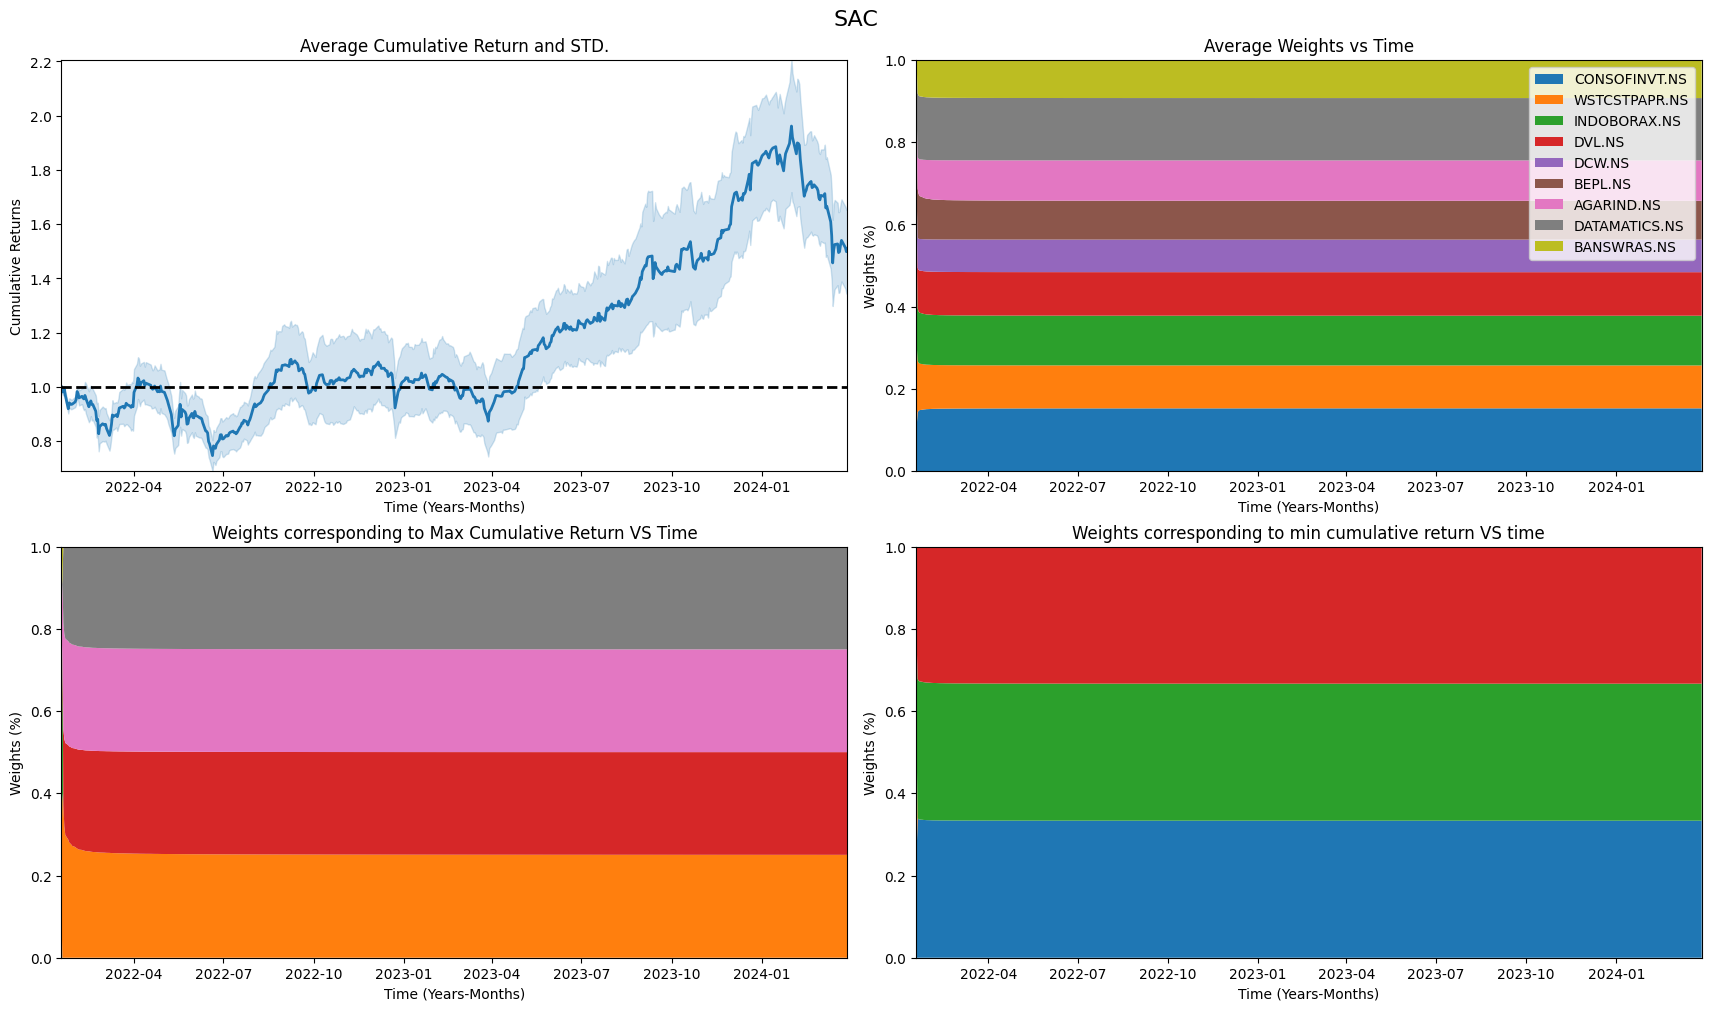

In [27]:
rl("SAC", data, trend)

In [28]:
import os
from google.colab import files

# List all files with .jpg extension in the current directory
jpg_files = [file for file in os.listdir(".") if file.endswith(".png")]

# Download each file
for file in jpg_files:
    files.download(file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>